# Introduction

This notebook is a workspace for the prediction of energy consumption level of a building. Climate change is an urgent, relevant and multi-dimensional global issue with a significant impact on energy policy and infrastructure. Tackling climate change involves both mitigation and adaption.

Together, we'll seek to predict the energy consumption level of buildings to using easy  easy-to-implement ML solutions with cutting-edge
strategies to help policy makers make informed decision.

The notebook is crafted on Google Colab and contain the step-by-step and thought process behind these strategies, with adequate justification of why each steps are taken.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Preparation
%cd /content/drive/MyDrive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


In [ ]:
# we Import necessary library to load and explore the dataset
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



In [ ]:
#Load the dataset
Climate=pd.read_csv("data.csv")

#make a copy of the dataset
Climate_copy=Climate.copy()

## Exploring The Dataset

In [ ]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

class PreprocessingLibrary:
    def __init__(self):
        self.categorical_encoders = {}
        self.scaler = None

    @staticmethod
    def handle_missing_values(df):
      df_temp = df.copy()  # Creating a copy to avoid modifying the original DataFrame
      df_temp = df_temp.dropna(thresh=len(df_temp) * 2 / 3, axis=1)

      for col in df_temp.columns:
          if df_temp[col].dtype == 'object' or pd.api.types.is_categorical_dtype(df_temp[col]):
              imputer = SimpleImputer(strategy='most_frequent')
          else:
              imputer = SimpleImputer(strategy='mean')
          df_temp[col] = imputer.fit_transform(df_temp[[col]])

      return df_temp


    @staticmethod
    def drop_duplicates(df):
        """
        Drops duplicate rows from the DataFrame.
        """
        return df.drop_duplicates()
    @staticmethod
    def outlier(df):
      numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
      for feature in numerical_features:
        q01, q99 = df[feature].quantile(0.01), df[feature].quantile(0.99)
       # Cap the outliers
        df[feature] = np.where(df[feature] < q01, q01, df[feature])
        df[feature] = np.where(df[feature] > q99, q99, df[feature])

      return df

    def fit_categorical_encoders(self, df, method='onehot'):
        """
        Fits categorical encoders on the DataFrame.
        """
        if method == 'onehot':
            self.categorical_encoders = OneHotEncoder(sparse=False)
            self.categorical_encoders.fit(df.select_dtypes(include=['object', 'category']))
        elif method == 'label':
            for col in df.select_dtypes(include=['object', 'category']).columns:
                encoder = LabelEncoder()
                encoder.fit(df[col])
                self.categorical_encoders[col] = encoder
    def transform_categorical(self, df):
      if isinstance(self.categorical_encoders, OneHotEncoder):
        # Identify columns to encode based on the encoder's original fitting
          columns_to_encode = self.categorical_encoders.feature_names_in_

        # Select only the columns that were originally used to fit the encoder
          encoded_data = self.categorical_encoders.transform(df[columns_to_encode])
          encoded_df = pd.DataFrame(encoded_data, columns=self.categorical_encoders.get_feature_names_out(columns_to_encode))

        # Drop the original categorical columns and join the new encoded DataFrame
          df = df.drop(columns=columns_to_encode, axis=1)
          df = df.join(encoded_df)
          return df

      elif isinstance(self.categorical_encoders, dict):
          for col, encoder in self.categorical_encoders.items():
              if col in df.columns:
                  df[col] = encoder.transform(df[col])
          return df


    def fit_scaler(self, df, method='standard'):
        """
        Fits the scaler on the DataFrame.
        """
        if method == 'standard':
            self.scaler = StandardScaler()
        elif method == 'minmax':
            self.scaler = MinMaxScaler()
        self.scaler.fit(df.select_dtypes(include=['float64', 'int64']))

    def transform_scale(self, df):
        """
        Scales numerical features in the DataFrame using the fitted scaler.
        """
        numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
        df[numerical_cols] = self.scaler.transform(df[numerical_cols])
        return df

    @staticmethod
    def split_dataset(df, test_size=0.2, random_state=42):
        """
        Splits the dataset into training and test sets.
        """
        return train_test_split(df, test_size=test_size, random_state=random_state)


In [ ]:
# Creating an instance of the Preprocessing Library
preprocessor = PreprocessingLibrary()

# Handling missing values and duplicates
df = preprocessor.handle_missing_values(Climate)
df= preprocessor.drop_duplicates(df)
df_clean=preprocessor.outlier(df)

In [ ]:
#checking the dimension of the dataset
df_clean.shape

(75757, 59)

In [ ]:
df_clean.drop("id", axis=1, inplace=True)
# Splitting the dataset
train_df, test_df = preprocessor.split_dataset(df_clean, test_size=0.25, random_state=42)
train_df.shape

(56817, 58)

In [ ]:
preprocessor.fit_categorical_encoders(train_df, method='onehot')
train_df_encoded = preprocessor.transform_categorical(train_df)

preprocessor.fit_scaler(train_df_encoded,  method= 'standard')
train_df_scaled = preprocessor.transform_scale(train_df_encoded)

# Transforming test data
test_df_encoded = preprocessor.transform_categorical(test_df)
test_df_scaled = preprocessor.transform_scale(test_df_encoded)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
train_df_scaled.shape

(56817, 124)

In [ ]:
#Printing all the variables in the dataset
Climate.columns

Index(['Year_Factor', 'State_Factor', 'building_class', 'facility_type',
       'floor_area', 'year_built', 'energy_star_rating', 'ELEVATION',
       'january_min_temp', 'january_avg_temp', 'january_max_temp',
       'february_min_temp', 'february_avg_temp', 'february_max_temp',
       'march_min_temp', 'march_avg_temp', 'march_max_temp', 'april_min_temp',
       'april_avg_temp', 'april_max_temp', 'may_min_temp', 'may_avg_temp',
       'may_max_temp', 'june_min_temp', 'june_avg_temp', 'june_max_temp',
       'july_min_temp', 'july_avg_temp', 'july_max_temp', 'august_min_temp',
       'august_avg_temp', 'august_max_temp', 'september_min_temp',
       'september_avg_temp', 'september_max_temp', 'october_min_temp',
       'october_avg_temp', 'october_max_temp', 'november_min_temp',
       'november_avg_temp', 'november_max_temp', 'december_min_temp',
       'december_avg_temp', 'december_max_temp', 'cooling_degree_days',
       'heating_degree_days', 'precipitation_inches', 'snowfall_inc

In [ ]:

#To display all possible rows and columns in the Output
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
#Checking the data types of each variales
Climate.dtypes

Year_Factor                    int64
State_Factor                  object
building_class                object
facility_type                 object
floor_area                   float64
year_built                   float64
energy_star_rating           float64
ELEVATION                    float64
january_min_temp               int64
january_avg_temp             float64
january_max_temp               int64
february_min_temp              int64
february_avg_temp            float64
february_max_temp              int64
march_min_temp                 int64
march_avg_temp               float64
march_max_temp                 int64
april_min_temp                 int64
april_avg_temp               float64
april_max_temp                 int64
may_min_temp                   int64
may_avg_temp                 float64
may_max_temp                   int64
june_min_temp                  int64
june_avg_temp                float64
june_max_temp                  int64
july_min_temp                  int64
j

### Summary Statistics


Summary statistics of the dataset gives us a thorough view of our dataset, covering both numerical and categorical data. We can get quick idea about the central tendency, dispersion, and shape of our dataset's distributions.

In [ ]:
#Doing summary statistics
summarystat= Climate.describe(include='all')
print(summarystat)

         Year_Factor State_Factor building_class              facility_type  \
count   75757.000000        75757          75757                      75757   
unique           NaN            7              2                         60   
top              NaN      State_6    Residential  Multifamily_Uncategorized   
freq             NaN        50840          43558                      39455   
mean        4.367755          NaN            NaN                        NaN   
std         1.471441          NaN            NaN                        NaN   
min         1.000000          NaN            NaN                        NaN   
25%         3.000000          NaN            NaN                        NaN   
50%         5.000000          NaN            NaN                        NaN   
75%         6.000000          NaN            NaN                        NaN   
max         6.000000          NaN            NaN                        NaN   

          floor_area    year_built  energy_star_rat

In [ ]:
#More descriptive statistics:
for col in Climate.select_dtypes(include=['object']).columns:
    mode_value = Climate[col].mode()[0]
    print(f"Mode for {col}: {mode_value}")

    standard_deviation = Climate['site_eui'].std()
print("Standard Deviation of the target variable:", standard_deviation)

Mode for State_Factor: State_6
Mode for building_class: Residential
Mode for facility_type: Multifamily_Uncategorized
Standard Deviation of the target variable: 58.255402659209146


From the descriptive statistics above, we can deduce that:

1. **Year_Factor**: Ranges from 1 to 6, suggesting a categorical variable that might represent years or time periods.
2. **State_Factor**: There are 7 unique state factors, and 'State_6' is the most frequent.
3. **Building_Class**: Mainly consists of 'Residential' and 'Commercial', but 'Residential' is more common.
4. **Facility_Type**: There are 60 unique types, with 'Multifamily_Uncategorized' being the most frequent.

5. **Floor_Area**: Varies widely (from 943 to about 6.4 million square feet).

6. **Year_Built**: Ranges from 0 (which might be a data error) to 2015. Most buildings were built around 1952.
7. **Energy_Star_Ratin**g: Ranges from 0 to 100. The mean rating is around 61, but about a third of this data is missing.
8. **Elevation**: Ranges from -6.4 to 1924.5, indicating varied geographical locations.
9. **Weather-Related Features**: Variables like january_min_temp, days_above_80F, etc., have wide ranges, indicating diverse climatic conditions across buildings.

Also, there are lot of missing values in some variables

### Checking missing data

From the summary statistics, it's evident that Several columns have significant number of missing values. Such columns include energy_star_rating, direction_max_wind_speed, direction_peak_wind_speed, and days_with_fog, all having more than 1/3 of their observations missing.

It's crucial to examine these columns with missing values as they can have huge impact on the model predictive power.

In [ ]:
missing_values = Climate.isnull().sum()
print(missing_values)

Year_Factor                      0
State_Factor                     0
building_class                   0
facility_type                    0
floor_area                       0
year_built                    1837
energy_star_rating           26709
ELEVATION                        0
january_min_temp                 0
january_avg_temp                 0
january_max_temp                 0
february_min_temp                0
february_avg_temp                0
february_max_temp                0
march_min_temp                   0
march_avg_temp                   0
march_max_temp                   0
april_min_temp                   0
april_avg_temp                   0
april_max_temp                   0
may_min_temp                     0
may_avg_temp                     0
may_max_temp                     0
june_min_temp                    0
june_avg_temp                    0
june_max_temp                    0
july_min_temp                    0
july_avg_temp                    0
july_max_temp       

In [ ]:
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percent})
print(missing_df.sort_values(by='Percentage', ascending=False))

                           Missing Values  Percentage
days_with_fog                       45796   60.451179
direction_peak_wind_speed           41811   55.190939
max_wind_speed                      41082   54.228652
direction_max_wind_speed            41082   54.228652
energy_star_rating                  26709   35.256148
year_built                           1837    2.424858
Year_Factor                             0    0.000000
november_max_temp                       0    0.000000
cooling_degree_days                     0    0.000000
december_max_temp                       0    0.000000
december_avg_temp                       0    0.000000
december_min_temp                       0    0.000000
october_avg_temp                        0    0.000000
november_avg_temp                       0    0.000000
november_min_temp                       0    0.000000
october_max_temp                        0    0.000000
precipitation_inches                    0    0.000000
october_min_temp            

By checking the percentage of missing values, we get a clear picture of how much missing values are in each columns. It'll be safe to drop the columns with more than one third missing values.

In [ ]:
# Dropping these columns
columns=cols_with_many_missing= ["days_with_fog","direction_peak_wind_speed","max_wind_speed", "direction_max_wind_speed", "energy_star_rating"]
Climate = Climate.drop(columns=cols_with_many_missing)

#Check new shape of our dataset
print(Climate.shape)
Climate.shape
Climate.head()

(75757, 59)


,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,26.500150,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,24.693619,2
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,48.406926,3
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,3.899395,4


Recall that the year_built column has some missing values too, rather than dropping it, imputation is more feasible and less likely to bias the results. we decide to use fill the missing values with median values of the columns as this statistical method is robust to outliers.

Furthermore, The year_built column  contains anomalous values(0). it's safe to assume that the 0 values in year inbuilt column is likely to be a data error or placeholder for missing values, as a year value of 0 is not feasible for a building's construction. We can also replace the 0 values with the median of the non zero values

### Anomalous Values

In [ ]:
Climate['year_built'].describe()


count    73920.000000
mean      1952.306764
std         37.053619
min          0.000000
25%       1927.000000
50%       1951.000000
75%       1977.000000
max       2015.000000
Name: year_built, dtype: float64

In [ ]:
# Directly replace 0 with NaN
Climate.loc[Climate['year_built'] == 0.0, 'year_built'] = pd.NA

# Calculate the median for 'Year_Built', excluding NaN values
median_year_built = Climate['year_built'].median(skipna=True)

# Replace NaN values in 'Year_Built' with the calculated median
Climate['year_built'].fillna(median_year_built, inplace=True)

In [ ]:
# Impute missing values in 'year_built' with the median
Climate['year_built'].fillna(Climate['year_built'].median(), inplace=True)

print(Climate['year_built'].isnull().sum())

0


In [ ]:
Climate.shape

(75757, 59)

### Dropping Duplicates

Duplicates introduce redundancy into our datasets and it's important to remove them to preserve the predictive power of our model.

In [ ]:
#Remove duplicates
Climate.drop_duplicates(keep= 'first', inplace= True)
Climate.shape

(75757, 59)

Upon futher inspection, we can deduce the "id" column may not have any significance to our model. This column is likely a unique identifier for each observation in the dataset so we can remove it.

In [ ]:
#remove "id" column
Climate.drop("id", axis=1, inplace=True)

#check if the change is implemented
Climate.shape

(75757, 58)

### Analyzing Relationships

We should create a correlation plots to help explore relationships between numerical variables and the target (site_eui).

It will be wise to exclude the monthly temperature-related columns for scatter plot analysis. This seems reasonable since these columns represent similar aspects of the climate data and could be redundant. Besides, the plots will be too much and making it difficult to make inference. Focusing on other significant numerical columns might yield more insightful results about factors influencing site_eui.

In [ ]:
Exclude = ['january_min_temp','january_avg_temp', 'january_max_temp',
           'february_min_temp','february_avg_temp', 'february_max_temp',
           'march_min_temp','march_avg_temp', 'march_max_temp',
           'april_min_temp', 'april_avg_temp','april_max_temp',
           'may_min_temp', 'may_avg_temp', 'may_max_temp',
            'june_min_temp', 'june_avg_temp', 'june_max_temp',
           'july_min_temp','july_avg_temp', 'july_max_temp',
           'august_min_temp', 'august_avg_temp','august_max_temp',
           'september_min_temp', 'september_avg_temp','september_max_temp',
           'october_min_temp', 'october_avg_temp', 'october_max_temp',
           'november_min_temp', 'november_avg_temp', 'november_max_temp',
           'december_min_temp', 'december_avg_temp','december_max_temp']



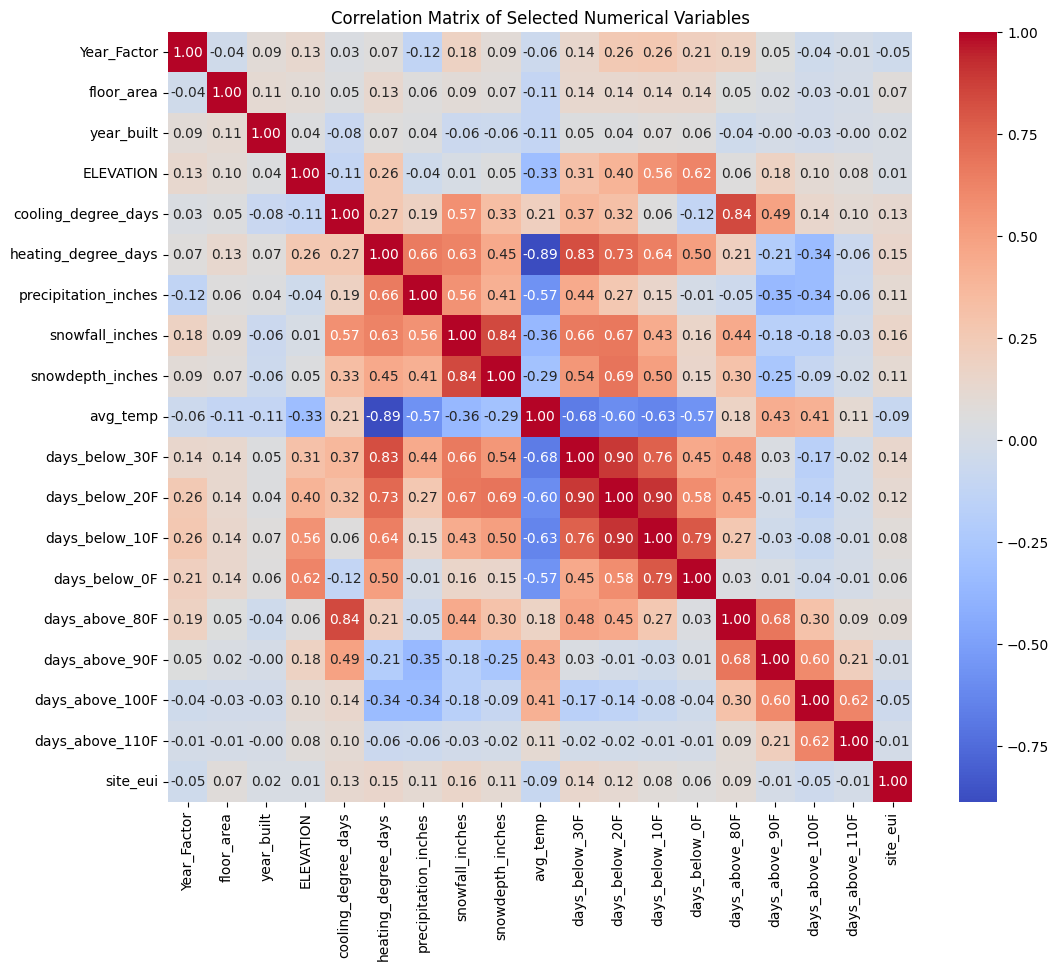

In [ ]:
# Selecting only the numerical columns and excluding the specified columns
selected_columns = Climate.select_dtypes(include=['float64', 'int64']).columns.drop(Exclude)
correlation_matrix = Climate[selected_columns].corr()

# Visualizing the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix of Selected Numerical Variables')
plt.show()

The correlation matrix reveal numerous informations.

1. The target variable site_eui does not seem to have strong correlations with any single variable, indicating that its prediction may require combining multiple features or more complex models that can capture non-linear relationships.

2. There's a clear pattern of negative correlation between variables related to heating (e.g., heating_degree_days) and those related to cooling (e.g., cooling_degree_days, days_above_80F, etc.). This reflects the inverse relationship between temperatures that require heating versus cooling.

3. Some pairs of features show high correlation with each other, which indicates potential collinearity. Dimensionality reduction techniques such as PCA will help us address these multicollinearity issues later.

4. The Year_Factor has little to no linear relationship with most variables, as indicated by the correlation coefficients being close to 0.


since the year factor has no relationships with any variables and even the target variable, we might consider dropping it.

In [ ]:
Climate.drop("Year_Factor", axis=1, inplace=True)
Climate.shape
Climate.columns
Climate_pip=Climate.copy() #To use in the pipeline
y=Climate['site_eui']
Climate=Climate.drop('site_eui', axis=1) #for consistency with pipeline


## Removing outliers
Now we can check for outliers in our dataset. Outliers are extreme values(large or small) that can disproportionately influence statistical or ML models. Removing these extreme values can lead to more accurate model predictive powers.

While there are different methods of removing outliers from a dataset, we'll be using the  Z-scores statistical metrics.


In [ ]:
from scipy import stats
import numpy as np
z_scores = np.abs(stats.zscore(Climate.select_dtypes(include=[np.number])))

#threshold
threshold = 3

# Identify rows with any outliers
outliers = np.any(z_scores > threshold, axis=1)

# Calculate the total number of outliers
total_outliers = np.sum(outliers)
print(total_outliers)


12179


We have more than 13,000 outliers as indicated the z scores metrics. It's important to understand the context crucially as removing them all without thorough inspection can lead to a significant information loss.

In [ ]:
# Identify rows with outliers
outliers = np.where(z_scores > threshold)

# Calculate the number of outliers in each column
num_outliers = np.sum(z_scores > threshold, axis=0)

# Print the number of outliers in each numeric column
print("Number of outliers in each numeric column:")
for col, num in zip(Climate.select_dtypes(include=[np.number]).columns, num_outliers):
    print(f"{col}: {num}")

Number of outliers in each numeric column:
floor_area: 1516
year_built: 103
ELEVATION: 875
january_min_temp: 1016
january_avg_temp: 229
january_max_temp: 1450
february_min_temp: 0
february_avg_temp: 7
february_max_temp: 100
march_min_temp: 204
march_avg_temp: 41
march_max_temp: 8
april_min_temp: 70
april_avg_temp: 682
april_max_temp: 110
may_min_temp: 80
may_avg_temp: 104
may_max_temp: 295
june_min_temp: 81
june_avg_temp: 475
june_max_temp: 2270
july_min_temp: 776
july_avg_temp: 1464
july_max_temp: 1210
august_min_temp: 1575
august_avg_temp: 1465
august_max_temp: 2137
september_min_temp: 58
september_avg_temp: 71
september_max_temp: 57
october_min_temp: 1014
october_avg_temp: 2196
october_max_temp: 761
november_min_temp: 307
november_avg_temp: 423
november_max_temp: 222
december_min_temp: 2614
december_avg_temp: 401
december_max_temp: 134
cooling_degree_days: 62
heating_degree_days: 2599
precipitation_inches: 2453
snowfall_inches: 2
snowdepth_inches: 3
avg_temp: 1858
days_below_30F: 13

From the boxplot we can deduce that it's mostly the monthly temperature data that has outliers. It's a tricky situation as outliers in temperature range require more context to make an informed decision. If we'll retain the outliers, then we should also seek to fit Ml models that are robust to outliers.

We can also do outliers capping Outlier, a process where we limit extreme values to a defined range based on statistical metrics such as the interquartile range (IQR). This is our most preferable option as removing the outliers outrighthly can lead to huge information loss and retaining them can also affect model performance and introduce bias. With this method, we can mitigate the effect of the outlier values without removing them.

### Feature Engineering

Based on insights from EDA, we can now create new features or modify existing ones to better capture information relevant to our target variable.

First, temperature related columns are too sparse(36 columns) and we can try and reduce/convert them from wide format to long format. We can consider creating average seasonal temperatures (e.g., winter_avg_temp, spring_avg_temp, summer_avg_temp, autumn_avg_temp) to reduce dimensionality and possibly capture more relevant patterns.



In [ ]:
#Code inspiration gotten from Stack Overflow and ChatGPT
# Define the seasons by months
seasons = {
    'Winter': ['december', 'january', 'february'],
    'Spring': ['march', 'april', 'may'],
    'Summer': ['june', 'july', 'august'],
    'Autumn': ['september', 'october', 'november']
}

# Calculate seasonal averages for each temperature type
for season, months in seasons.items():
    for temp_type in ['min_temp', 'avg_temp', 'max_temp']:
        month_columns = [f'{month}_{temp_type}' for month in months]
        Climate[f'{season}_{temp_type}'] = Climate[month_columns].mean(axis=1)
# drop the monthly temperature related columns
Climate_cleaned= Climate.drop(columns=Exclude)

In [ ]:
Climate_cleaned.shape

(75757, 32)

In [ ]:
Climate_after_seasonal=Climate_cleaned.copy()


In [ ]:
X = Climate_cleaned
#Splitting the Dataset
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test= train_test_split(X,y, test_size=0.25, random_state=42)
X_train.shape

(56817, 32)

### Encoding our categorical variables

We use one-hot encoding  to convert categorical varibales to numerical values that can be used in the model.



In [ ]:
# Identifying categorical columns and numerical columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
numerical_cols= X_train.select_dtypes(include=['int', 'float64']).columns
numerical_cols
categorical_cols

Index(['State_Factor', 'building_class', 'facility_type'], dtype='object')

In [ ]:

from sklearn.preprocessing import OneHotEncoder

# Identifying categorical columns and numerical columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
numerical_cols= X_train.select_dtypes(include=['int', 'float64']).columns

# Initializing OneHotEncoder from sklearn
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

# Fitting the encoder on the training data
encoder.fit(X_train[categorical_cols])

# Transforming training data
X_train_encoded = encoder.transform(X_train[categorical_cols])
X_train_encoded= pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(categorical_cols))

# Transforming test data
X_test_encoded = encoder.transform(X_test[categorical_cols])
X_test_encoded = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(categorical_cols))

# Joining the encoded data with the original data

X_train_encoded = pd.concat([X_train.drop(columns=categorical_cols).reset_index(drop=True),
                                   X_train_encoded.reset_index(drop=True)], axis=1)

X_test_encoded = pd.concat([X_test.drop(columns=categorical_cols).reset_index(drop=True),
                                  X_test_encoded.reset_index(drop=True)], axis=1)

# Now, Climate_train_encoded and Climate_test_encoded have the original data with categorical columns replaced by one-hot encoded versions.

X_train_encoded.shape

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(56817, 98)

### Side Note.

We plot the decision Tree as required in the slide Lab

In [ ]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Initialize the Decision Tree model
model_dt = DecisionTreeRegressor()

# Fit the model on the training data
model_dt.fit(X_train_encoded, y_train)

# Predict on the test data
y_pred_dt = model_dt.predict(X_test_encoded)

# Evaluate the model
mse_dt = mean_squared_error(y_test, y_pred_dt, squared=False)
print(f"Root Mean Squared Error: {mse_dt}")
r2_scores_dt=r2_score(y_test, y_pred_dt)
print(r2_scores_dt)

Root Mean Squared Error: 59.505803068144665
-0.08432674391886641


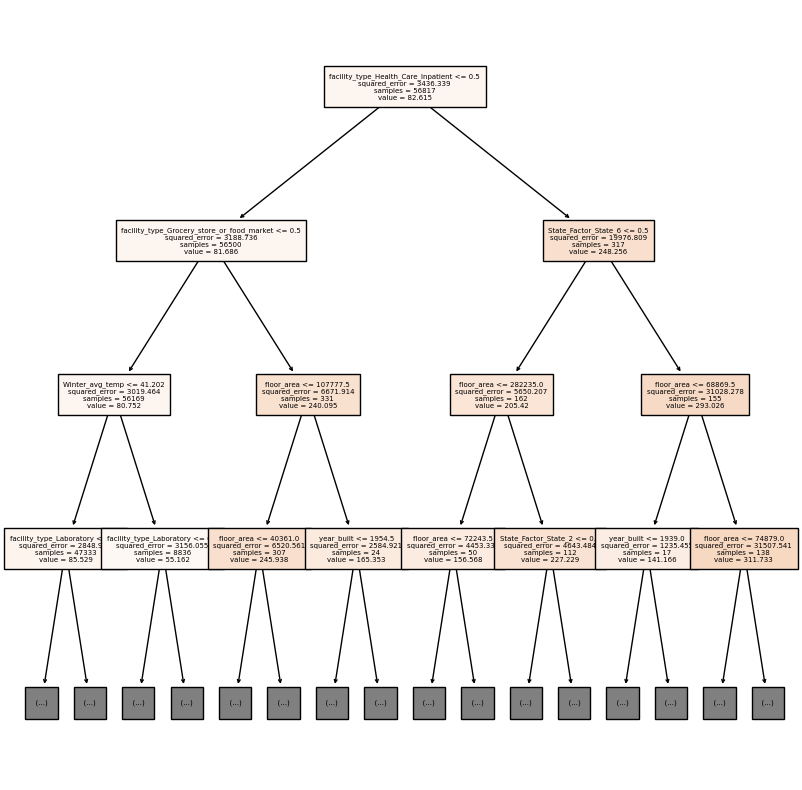

In [ ]:
plt.figure(figsize=(10,10))
plot_tree(model_dt,
          filled=True,
          feature_names=X_train_encoded.columns.to_list(),
          max_depth=3,  # Limiting tree depth for visibility
          fontsize=5)
plt.show()

The decision tree image above can give us quick overview of what the model is doing in the background. From the image, we can see that The Root node is the Days_above_100F and the first split is based on the Days_above_100F < 0.5).Each branch continues to split based on different features like Days_above_110F, June_Min_Temp floor_area, year_built, and Summer_min_temp. Each condition for splitting (e.g., facility_type_Health_Care_Inpatient < 0.5) is a binary decision that guides the flow down the tree.
The leaf node values are not visible in the image but they represent the final decision points where the model makes a prediction. The predictions are based on the mean target value of the samples that end up in each leaf after all the splits.

### Standardizing Our Numerical Features
Feature scaling is important so all our features have comparable range of values to each other

In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the numerical columns of the training data
X_train_scaled = scaler.fit_transform(X_train_encoded[numerical_cols])

# Transform the numerical columns of the test data
X_test_scaled = scaler.transform(X_test_encoded[numerical_cols])

# Create DataFrames from the scaled features for easier concatenation
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=numerical_cols, index=X_train_encoded.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=numerical_cols, index=X_test_encoded.index)

# Drop the original numerical columns
X_train_encoded_dropped = X_train_encoded.drop(columns=numerical_cols)
X_test_encoded_dropped = X_test_encoded.drop(columns=numerical_cols)

# Concatenate the scaled numerical DataFrames with the remaining encoded datasets
X_train_final = pd.concat([X_train_encoded_dropped, X_train_scaled_df], axis=1)
X_test_final = pd.concat([X_test_encoded_dropped, X_test_scaled_df], axis=1)

# Fitting our first model.



### Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the model
model_lr= LinearRegression()

# Fit the model on the training data
model_lr.fit(X_train_final, y_train)

# Predict on the test data
y_pred_lr = model_lr.predict(X_test_final)

# Evaluate the model
rmse_lr = mean_squared_error(y_test, y_pred_lr, squared=False)#to get rmse value
r2 = r2_score(y_test, y_pred_lr)

print(f"Root Mean Squared Error: {rmse_lr}")
print(f"R^2 Score: {r2}")

Root Mean Squared Error: 49.859617559510056
R^2 Score: 0.238728775529765


The model performs very poorly with r2 score of 0.2. We try more model to see if we can improve the performance.

### KFold Cross Validation

In [ ]:
#Code copied from the LinearRegression Class Exercise.

from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import pandas as pd

X = X_train_final
y_copy=y.copy()
y = y_train

# Initialize KFold with shuffling
kf = KFold(n_splits=5, shuffle=True, random_state=None)

# Create a linear regression model
regr_cv = LinearRegression()

# Perform cross-validation
rmse_scores = []
r2_scores= []

for train_index, test_index in kf.split(X):
    # Use .iloc for Pandas DataFrame/Series
    X_train_final,X_test_final = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit and predict
    regr_cv.fit(X_train_final, y_train)
    y_pred = regr_cv.predict(X_test_final)

    # Calculate MSE
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    rmse_scores.append(rmse)

    #r2 scores
    r2=r2_score(y_test, y_pred)
    r2_scores.append(r2)

print("RMSE Scores:", rmse_scores)
print("R2 scores:", r2_scores)

RMSE Scores: [51.161799324490104, 50.74828934702921, 48.459372875251134, 52.94922995099462, 52.63665693099993]
R2 scores: [0.24622935104624522, 0.2313972204920589, 0.25927110812380616, 0.20524205917503768, 0.24285222307115306]


The relatively high RMSE scores and low R² scores across all folds suggest that the linear regression model may not be adequately capturing the relationships in the data, implying the model is not performing very well.

In [ ]:
#import ElasticNetCV
from sklearn.linear_model import ElasticNetCV

# Create ElasticNetCV model with a range of alpha values
alphas = np.logspace(-5, -4, 10)
l1_ratios = np.linspace(0.1, 1, 10)
elastic_net_cv = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=5, max_iter=100000, tol=1e-4)

# Fit the Elastic Net model
elastic_net_cv.fit(X_train_final, y_train)

# Get the best alpha and l1_ratio
best_alpha = elastic_net_cv.alpha_
best_l1_ratio = elastic_net_cv.l1_ratio_

print(f'Best alpha: {best_alpha:.6f}')
print(f'Best l1_ratio: {best_l1_ratio:.2f}')

# Predict on the test set
y_pred = elastic_net_cv.predict(X_test_final)

# Calculate the Mean Squared Error on the test set
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Root Mean Squared Error on the test set: {rmse:.2f}')
r2_elastic =r2_score(y_test, y_pred)
print(f'R2 score on the test set: {r2_elastic:.2f}')


Best alpha: 0.000100
Best l1_ratio: 0.10
Root Mean Squared Error on the test set: 52.65
R2 score on the test set: 0.24


The ElasticNetCV performs relatively similar to the LinearRegression so there's still room for improvement

### Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Fit the model on the training data
rf.fit(X_train_final, y_train)

# Predict on the testing data
y_pred_rf = rf.predict(X_test_final)

# Calculate the Mean Squared Error
rmse_rf =np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
print(f'Random Forest Regression MSE: {rmse_rf}')
print(f'R2 Score for Random Forest Regression: {r2_rf}')

Random Forest Regression MSE: 47.55750285937716
R2 Score for Random Forest Regression: 0.3819236303164135


## Dimensionality Reduction


### PCA

PCA can help reduces dimensionality by transforming the original variables into a new set of variables (the principal components). PCA might help us combine features to create components that capture the most variance in the data, thus helping us improve model prediction

In [ ]:
from sklearn.decomposition import PCA

# Initialize PCA
pca = PCA(n_components=0.95) #this instance retains components that explain 95% of the variance

# Apply PCA
X_train_pca = pca.fit_transform(X_train_final)
X_test_pca= pca.transform(X_test_final)

# Create a new DataFrame with the PCA features
df_pca = pd.DataFrame(X_train_pca)
principalDf = pd.DataFrame(data = df_pca
             , columns = ['principal component 1', 'principal component 2'])
# Check the shape of the new DataFrame
print("Original shape:", X_train_final.shape)
print("Reduced shape:", df_pca.shape)

# Check the number of components and explained variance
print("Number of components:", pca.n_components_)
print("Explained variance ratio:", pca.explained_variance_ratio_.sum())

Original shape: (45454, 98)
Reduced shape: (45454, 12)
Number of components: 12
Explained variance ratio: 0.9546856458824702


#### Scree Plot

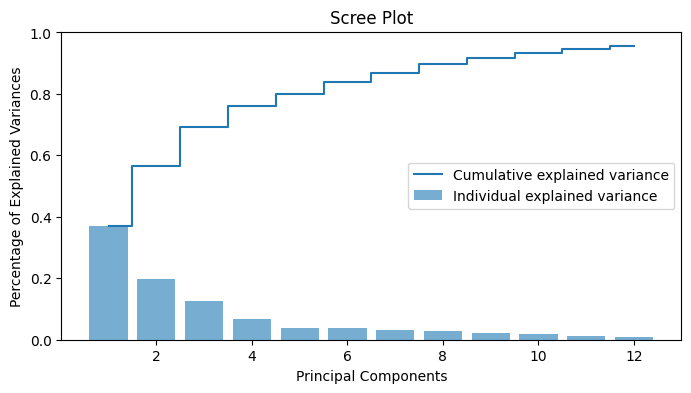

In [ ]:
#code inspiration gotten from ChatGPT and StackOVerflow
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# The amount of variance that each PC explains
variance = pca.explained_variance_ratio_

# Cumulative variance explains
cumulative_variance = np.cumsum(variance)

# Plotting the scree plot
plt.figure(figsize=(8, 4))
plt.bar(range(1, len(variance) + 1), variance, alpha=0.6, align='center', label='Individual explained variance')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative explained variance')
plt.ylabel('Percentage of Explained Variances')
plt.xlabel('Principal Components')
plt.legend(loc='best')
plt.title('Scree Plot')
plt.show()

The PCA plot above shows both the individual and cumulative explained variances by the principal components. The x-axis shows the principal component number, and the y-axis shows the percentage of variance explained. However, it's evident that we need to retain many components to capture a significant portion of the variance, it may indicate that PCA is not reducing the dimensionality by much, or the data does not have a linear structure that PCA can summarily reduce.

This is not suprising as we applied PCA after creating seasonal averages, the resulting principal components is less interpretable, as they are linear combinations of all input features, including the engineered seasonal ones.

In practice, we could perform PCA on the original monthly data first and assess model performance. Then, separately, we could create seasonal averages, apply PCA to these new features along with the others, and compare the results.

### Side Note: tSNE Plot

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.065s...
[t-SNE] Computed neighbors for 20000 samples in 2.130s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for sa

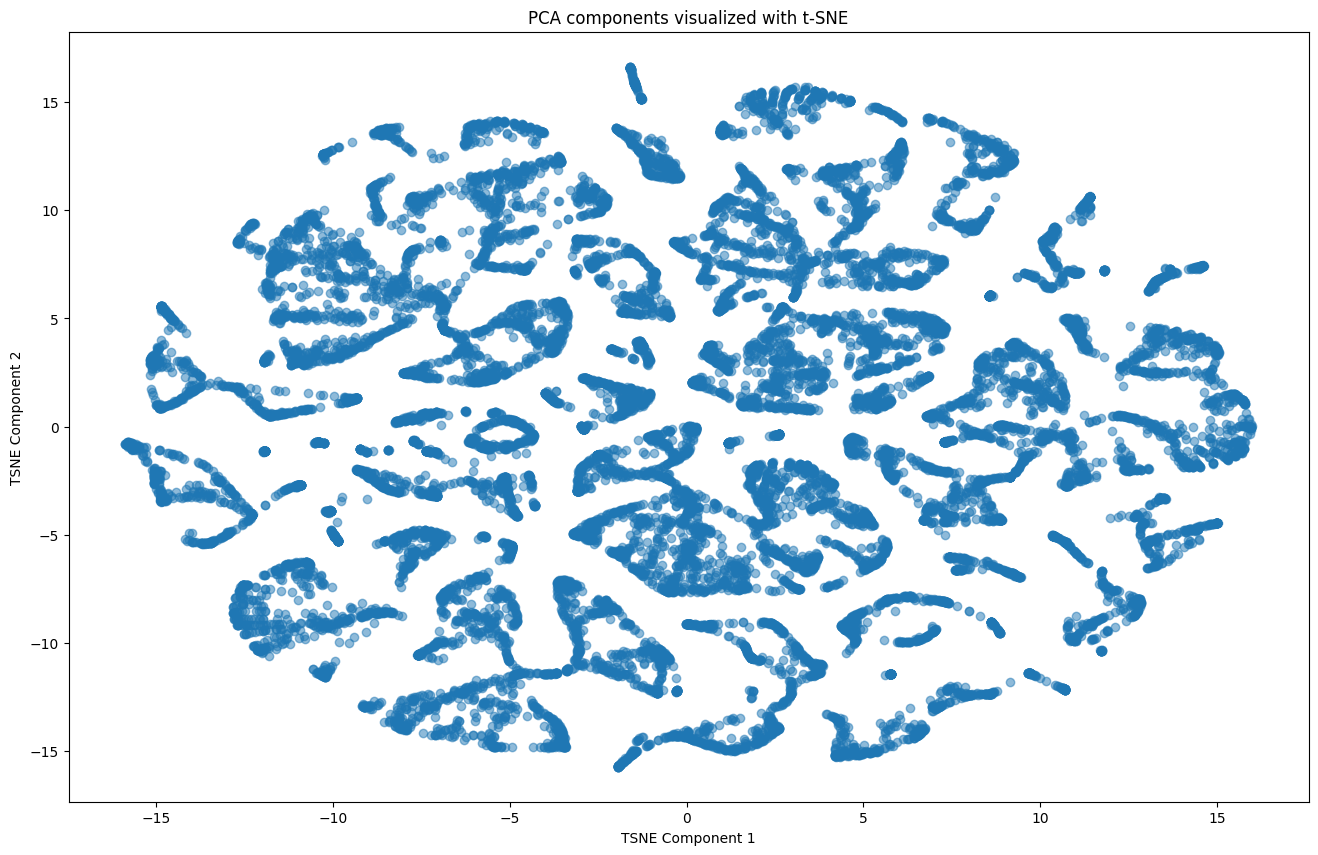

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# The data is too large so we generate a subset of the data
sampled_df = df_pca.sample(n=20000, random_state=42)

# Apply t-SNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(sampled_df)

# Plotting the t-SNE result
plt.figure(figsize=(16,10))
plt.scatter(tsne_results[:,0], tsne_results[:,1], alpha=0.5)
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.title('PCA components visualized with t-SNE')
plt.show()

From our end here, the plot shows a clear pattern of clusters, suggesting that our data has groups of points that are similar to each other.

### USing the PCA in the Model

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Initialize the Linear Regression model
lr = LinearRegression()

# Fit the model on the training data
lr.fit(X_train_pca, y_train)

# Predict on the testing data
y_pred_lr = lr.predict(X_test_pca)

# Calculate the Mean Squared Error
rmse_lr = mean_squared_error(y_test, y_pred_lr, squared=False)
r2_scores_lr=r2_score(y_test, y_pred_lr)
print(rmse_lr, r2_scores_lr)

59.346498557457856 0.037514366117007536


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Fit the model on the training data
rf.fit(X_train_pca, y_train)

# Predict on the testing data
y_pred_rf = rf.predict(X_test_pca)

# Calculate the Mean Squared Error
mse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f'Random Forest Regression MSE: {mse_rf}')
r2_scores_rf =r2_score(y_test, y_pred_rf)
print(r2_scores_rf)

Random Forest Regression MSE: 60.21003053387632
0.009300943331651546


In [ ]:
from sklearn.svm import SVR

# Initialize the Support Vector Regressor
svr = SVR()

# Fit the model on the training data
svr.fit(X_train_pca, y_train)

# Predict on the testing data
y_pred_svr = svr.predict(X_test_pca)

# Calculate the Mean Squared Error
rmse_svr = mean_squared_error(y_test, y_pred_svr, squared=False)
print(f'Support Vector Regression RMSE: {rmse_svr}')
mse_svr = mean_squared_error(y_test, y_pred_svr)

Support Vector Regression RMSE: 60.08691953305892


In [ ]:
y.shape

(56817,)

### Using PCA on the Non Engineered Dataset

In [ ]:
X = Climate_after_outlier_capping

#Splitting the Dataset
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test= train_test_split(X,y_copy, test_size=0.25, random_state=42)
X_train.shape

# Identifying categorical columns and numerical columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
numerical_cols= X_train.select_dtypes(include=['int', 'float64']).columns

#Encoding
from sklearn.preprocessing import OneHotEncoder


# Initializing OneHotEncoder from sklearn
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

# Fitting the encoder on the training data
encoder.fit(X_train[categorical_cols])

# Transforming training data
X_train_encoded = encoder.transform(X_train[categorical_cols])
X_train_encoded= pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(categorical_cols))

# Transforming test data
X_test_encoded = encoder.transform(X_test[categorical_cols])
X_test_encoded = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(categorical_cols))

# Joining the encoded data with the original data

X_train_encoded = pd.concat([X_train.drop(columns=categorical_cols).reset_index(drop=True),
                                   X_train_encoded.reset_index(drop=True)], axis=1)

X_test_encoded = pd.concat([X_test.drop(columns=categorical_cols).reset_index(drop=True),
                                  X_test_encoded.reset_index(drop=True)], axis=1)

X_train_encoded.shape

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(56817, 122)

In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the numerical columns of the training data
X_train_scaled = scaler.fit_transform(X_train_encoded[numerical_cols])

# Transform the numerical columns of the test data
X_test_scaled = scaler.transform(X_test_encoded[numerical_cols])

# Create DataFrames from the scaled features for easier concatenation
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=numerical_cols, index=X_train_encoded.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=numerical_cols, index=X_test_encoded.index)

# Drop the original numerical columns
X_train_encoded_dropped = X_train_encoded.drop(columns=numerical_cols)
X_test_encoded_dropped = X_test_encoded.drop(columns=numerical_cols)

# Concatenate the scaled numerical DataFrames with the remaining encoded datasets
X_train_final2 = pd.concat([X_train_encoded_dropped, X_train_scaled_df], axis=1)
X_test_final2 = pd.concat([X_test_encoded_dropped, X_test_scaled_df], axis=1)

In [ ]:
from sklearn.decomposition import PCA

# Initialize PCA
pca2 = PCA(n_components=0.95) #this instance retains components that explain 95% of the variance

# Apply PCA
X_train_pca2 = pca2.fit_transform(X_train_final2)
X_test_pca2= pca2.transform(X_test_final2)

# Create a new DataFrame with the PCA features
df_pca2 = pd.DataFrame(X_train_pca2)
principalDf2 = pd.DataFrame(data = df_pca2
             , columns = ['principal component 1', 'principal component 2'])
# Check the shape of the new DataFrame
print("Original shape:", X_train_final2.shape)
print("Reduced shape:", df_pca2.shape)

# Check the number of components and explained variance
print("Number of components:", pca2.n_components_)
print("Explained variance ratio:", pca2.explained_variance_ratio_.sum())

Original shape: (56817, 122)
Reduced shape: (56817, 14)
Number of components: 14
Explained variance ratio: 0.9543612974705389


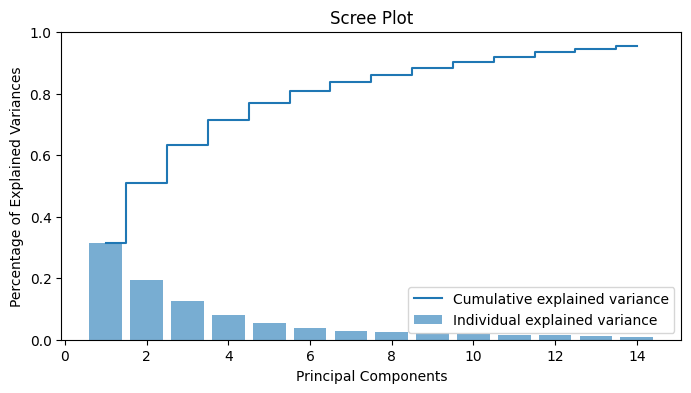

In [ ]:
#code inspiration gotten from ChatGPT and StackOVerflow
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# The amount of variance that each PC explains
variance2 = pca2.explained_variance_ratio_

# Cumulative variance explains
cumulative_variance2 = np.cumsum(variance2)

# Plotting the scree plot
plt.figure(figsize=(8, 4))
plt.bar(range(1, len(variance2) + 1), variance2, alpha=0.6, align='center', label='Individual explained variance')
plt.step(range(1, len(cumulative_variance2) + 1), cumulative_variance2, where='mid', label='Cumulative explained variance')
plt.ylabel('Percentage of Explained Variances')
plt.xlabel('Principal Components')
plt.legend(loc='best')
plt.title('Scree Plot')
plt.show()


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Initialize the Linear Regression model
lr = LinearRegression()

# Fit the model on the training data
lr.fit(X_train_pca2, y_train)

# Predict on the testing data
y_pred_lr = lr.predict(X_test_pca2)

# Calculate the Mean Squared Error
rmse_lr = mean_squared_error(y_test, y_pred_lr, squared=False)
r2_scores_lr=r2_score(y_test, y_pred_lr)
print(rmse_lr, r2_scores_lr)

55.647084933268836 0.051742326747742706


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Fit the model on the training data
rf.fit(X_train_pca2, y_train)

# Predict on the testing data
y_pred_rf = rf.predict(X_test_pca2)

# Calculate the Mean Squared Error
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f'Random Forest Regression RMSE: {rmse_rf}')
r2_scores_rf =r2_score(y_test, y_pred_rf)
print(r2_scores_rf)

Random Forest Regression RMSE: 57.17384493092613
-0.0010051847515011314


In [ ]:
from sklearn.svm import SVR

# Initialize the Support Vector Regressor
svr = SVR()

# Fit the model on the training data
svr.fit(X_train_pca2, y_train)

# Predict on the testing data
y_pred_svr = svr.predict(X_test_pca2)

# Calculate the Mean Squared Error
rmse_svr = mean_squared_error(y_test, y_pred_svr, squared=False)
print(f'Support Vector Regression RMSE: {rmse_svr}')
r2_scores_svr =r2_score(y_test, y_pred_svr)
print(r2_scores_svr)


Support Vector Regression RMSE: 56.36272914786601
0.02719553324492785


###Comment.

Whichever way we want to look at it, PCA doesnt improve our model performance whether we use it on Engineered dataset or not. However, we can deduce that there's a noticeable increase in the MSE score but sharp decline in the R2 score. As such, it's important to find a good balance and choose a model that offers a blend of both world.

## ML PipeLine

In modern ML practice ML Pipeline is important to incorporate all the entrie preprocssing and modeling steps into a single, coherent process. Now that we understand all the important preprocessing steps and the best model for our dataset, we can include it in the dataset. This will ensure reproducibility consistency and ease of deployment. The following sessions will develop a ML pipeline based on the steps we've taken so far using the original dataset



Below is an overview of all the steps we've taken so far and the model with the best result:

1.Load Dataset:

2. Import and load the dataset into the working environment.
3. Direct Replacement of Specific Values in 'year_built':
4. Drop Misssing Values
5. Drop Duplicates:
6. Drop Specific Features ("id" and "year Factor")

7. Feature Engineering - Seasonal Average Temperature:

8. Outliers Capping for Numerical Features:
For each numerical feature, calculate the 1st and 99th percentiles.
Cap values below the 1st percentile to the 1st percentile value and values above the 99th percentile to the 99th percentile value.

9. Encode Categorical Features and Standardize Numerical Features.

10. Split Dataset into Train and Test Dataset

11. Fit and Train Model using RandomForestRegressor(Gives the lowest MSE value.

12. Assess the model's performance on the test set and adjust hyperparameters as needed.

Now we incorporate Everything In the ML Model. However, steps like dropping duplicates, and Dropping Columns with High Missing Values will be excluded. This is because these are part of the data cleaning stages and are one-time data cleaning operation.



In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score

# Outlier Capper Function
def cap_outliers(df, numerical_features):
    for feature in numerical_features:
        # we Check if the feature is not the target variable
        if feature != 'site_eui':
            q01, q99 = df[feature].quantile(0.01), df[feature].quantile(0.99)
            df[feature] = np.where(df[feature] < q01, q01, df[feature])
            df[feature] = np.where(df[feature] > q99, q99, df[feature])
    return df

# Feature Engineering: Seasonal Temperature Calculation
class SeasonalTemperature(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        seasons = {
            'Winter': ['december', 'january', 'february'],
            'Spring': ['march', 'april', 'may'],
            'Summer': ['june', 'july', 'august'],
            'Autumn': ['september', 'october', 'november']
        }
        for season, months in seasons.items():
            for temp_type in ['min_temp', 'avg_temp', 'max_temp']:
                month_columns = [f'{month}_{temp_type}' for month in months]
                X[f'{season}_{temp_type}'] = X[month_columns].mean(axis=1)
        # Drop columns after checking
        exclude = [col for col in X.columns if 'temp' in col and not col.startswith(('Winter', 'Spring', 'Summer', 'Autumn'))]
        return X.drop(columns=exclude)



In [ ]:
# Splitting the data
X = Climate_pip.drop('site_eui', axis=1)
y = Climate_pip['site_eui']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
# Create the pipeline
pipeline = Pipeline([
    ('outlier_capper', FunctionTransformer(cap_outliers, kw_args={'numerical_features': X_train.select_dtypes(include=[np.number]).columns.tolist()})),
    ('seasonal_temp', SeasonalTemperature()),
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), make_column_selector(dtype_include=np.number)),
            ('cat', OneHotEncoder(), make_column_selector(dtype_include=object))
        ]
    )),
    ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
])

In [ ]:

# Fit the pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('outlier_capper',
                 FunctionTransformer(func=<function cap_outliers at 0x7e7a884b7250>,
                                     kw_args={'numerical_features': ['floor_area',
                                                                     'year_built',
                                                                     'ELEVATION',
                                                                     'january_min_temp',
                                                                     'january_avg_temp',
                                                                     'january_max_temp',
                                                                     'february_min_temp',
                                                                     'february_avg_temp',
                                                                     'february_max_temp',
                                                                     'march_min_temp',
                                                                     'march_avg_temp',
                                                                     'march_max_temp',
                                                                     'april_min_temp...
                ('seasonal_temp', SeasonalTemperature()),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7e7a8896b580>),
                                                 ('cat', OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7e7a8896a9e0>)])),
                ('model', RandomForestRegressor(n_jobs=-1, random_state=42))])

In [ ]:
# Predict and evaluate
predictions = pipeline.predict(X_test)
mse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')

Mean Squared Error: 43.85949760647043
R2 Score: 0.41092738514199845


Summary:

The notebook discusses the thought process in handling the project.It includes the comprehensive report of data cleaning, preprocessing, model selection and building pipeline. The major challenges face is computational power and we're limited to the hyperparamter tuning to do.